In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import os
plt.style.use('ggplot')

In [3]:
# Load titanic data frame, create new columns 'dataset' then concatenate the 2 data
train = pd.read_csv('../datasets/titanic/train.csv')
test = pd.read_csv('../datasets/titanic/test.csv')

titanic_train = train.copy()
titanic_test = test.copy()

titanic_train['Dataset'] = 'train'
titanic_test['Dataset'] = 'test'


In [27]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Dataset        418 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB


In [4]:
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

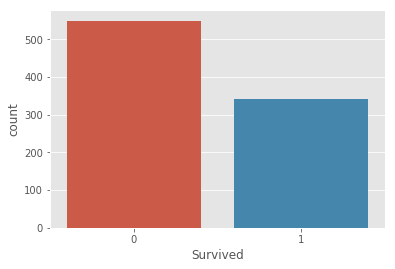

In [5]:
sns.countplot(train['Survived'])

In [6]:
train['Survived'].groupby(train['Pclass']).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

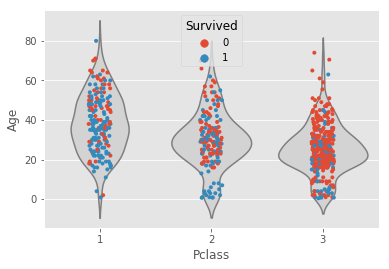

In [7]:
# Plotting Survival with age, there are many 20 plus people that did not make it, 
# as for Pclass, a lot of class 3 passenger were not able to survive the tragedy.
sns.violinplot(x = 'Pclass', y = 'Age', data = train, inner = None, color = 'lightgray')
sns.stripplot(x = 'Pclass', y = 'Age', data = train, size = 4, jitter= True, hue = 'Survived')
plt.show()

In [10]:
titanic_train['Name_Title'] = titanic_train['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
titanic_train['Name_Title'].value_counts()



Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Mlle.          2
Col.           2
Sir.           1
Mme.           1
the            1
Ms.            1
Don.           1
Lady.          1
Capt.          1
Jonkheer.      1
Name: Name_Title, dtype: int64

In [11]:
titanic_train['Name_len'] = titanic_train['Name'].apply(lambda x: len(x))
titanic_train['Survived'].groupby(pd.qcut(titanic_train['Name_len'],5)).mean()

Name_len
(11.999, 19.0]    0.220588
(19.0, 23.0]      0.301282
(23.0, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64

In [13]:
titanic_train['Survived'].groupby(pd.qcut(titanic_train['Age'],5)).mean()

Age
(0.419, 19.0]    0.481707
(19.0, 25.0]     0.328467
(25.0, 31.8]     0.393701
(31.8, 41.0]     0.437500
(41.0, 80.0]     0.373239
Name: Survived, dtype: float64

In [18]:
titanic_train['Ticket_Len'] = titanic_train['Ticket'].apply(lambda x: len(x))

In [19]:
titanic_train['Ticket_Lett'] = titanic_train['Ticket'].apply(lambda x: str(x)[0])

In [20]:
titanic_train['Ticket_Lett'].value_counts()

3    301
2    183
1    146
P     65
S     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: Ticket_Lett, dtype: int64

In [21]:
titanic_train.groupby(['Ticket_Lett'])['Survived'].mean()


Ticket_Lett
1    0.630137
2    0.464481
3    0.239203
4    0.200000
5    0.000000
6    0.166667
7    0.111111
8    0.000000
9    1.000000
A    0.068966
C    0.340426
F    0.571429
L    0.250000
P    0.646154
S    0.323077
W    0.153846
Name: Survived, dtype: float64

In [24]:
titanic_train['Cabin_Letter'] = titanic_train['Cabin'].apply(lambda x: str(x)[0])

In [23]:
titanic_train['Cabin_num'] = titanic_train['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
titanic_train['Cabin_num'].replace('an', np.NaN, inplace = True)
titanic_train['Cabin_num'] = titanic_train['Cabin_num'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)

In [25]:
tickets = titanic_train.loc[:,'Ticket'].value_counts()

from collections import defaultdict

ticket_cnt = defaultdict(int)
for x in range(len(tickets)):
    ticket_cnt[tickets.index[x]] = tickets.values[x]


In [26]:
# Dividing joint ticket fare within all passengers for that ticket
def get_new_fare(passenger):
    ticket, fare = passenger
    if ticket in ticket_cnt:
        return round(fare/ticket_cnt[ticket],2)

# Creating new column for number of passengers in joint ticket
def joint_ticket_check(passenger):
    ticket = passenger
    if ticket in ticket_cnt:
        return ticket_cnt[ticket]
    
titanic_train['New_Fare'] = titanic_train[['Ticket','Fare']].apply(get_new_fare, axis =1)
# titanic['passengers_in_ticket'] = titanic['ticket'].apply(joint_ticket_check)

In [ ]:
# passengers are list of tuples that hold all info for NULL Age, found in Titanic Encyclopedia Website
from passengers import passengers

titanic_train.loc[(titanic_train.age.isnull()) & (titanic_train.title == 'Dr'), 'Age'] = 46

# Going thru all the list of passengers in passengers.py
for x in passengers:
    titanic_train.loc[(titanic_train.ticket == x[0]) & (titanic_train.fname == x[1]), 'Age'] = x[2]

# Using median for the rest of the missing age for 'Miss' title
titanic_train.loc[(round(titanic_train.fare, 2) == titanic_train.new_fare) & (titanic_train.sibsp == 0) & (titanic_train.parch == 0) 
            & (titanic_train.age.isnull()) & (titanic_train.new_title == 'Miss'), 'Age'] = 24

# Setting age for passengers with title Mrs using mean with respect to pclass, 
titanic_train.loc[(titanic_train.age.isnull()) & (titanic_train.title == 'Mrs') & (titanic_train.pclass == 1), 'age'] = 45
titanic_train.loc[(titanic_train.age.isnull()) & (titanic_train.title == 'Mrs') & (titanic_train.pclass == 3), 'age'] = 31
titanic_train.loc[(round(titanic_train.fare, 2) == titanic_train.new_fare) & (titanic_train.sibsp == 0) & (titanic_train.parch == 0) 
            & (titanic_train.age.isnull()) & (titanic_train.title == 'Mr'), 'age'] = 29

"""

In [ ]:
"""
# Getting new_fare for the fare that was NULL
titanic_train.loc[titanic_train.fare.isnull(), 'new_fare'] = 7.8

# Upon searching the NULL embarked, were seen to have embarked on S
titanic.loc[titanic.embarked.isnull(), 'embarked'] = 'S'

# Changing the relationship of joint ticket 2662, they were father and son
titanic.loc[titanic.ticket == '2662',['sibsp','parch']] = [1,1]
titanic.loc[(titanic.ticket == '2662') & (titanic.fname == 'Hanna'),['sibsp','parch']] = [0,2]

# Setting Cabin for Peter Family to match Anna's
titanic.loc[(titanic.ticket == '2668'), 'cabin'] = 'F E69'

# Changing Bourke's Age and its sibsp and parch
titanic.loc[(titanic.lname == 'Bourke') & (titanic.age.isnull()), ['sibsp', 'parch', 'age']] = [1, 0, 40]

# Converting Fare for Hagland as it is eronous
titanic.loc[titanic.lname == 'Hagland', 'new_fare'] = round(19.9667/3,2)
titanic.loc[(titanic.age.isnull()), 'title'].value_counts()


"""

In [28]:
def names(train, test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
        del i['Name']
    return train, test

def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Name_Title', 'Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train, test

def fam_size(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , 'Solo',
                           np.where((i['SibSp']+i['Parch']) <= 3,'Nuclear', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test

def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x: str(x))
        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['Ticket_Lett'],
                                   np.where((i['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test

def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test


def cabin_num(train, test):
    for i in [train, test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    return train, test

def embarked_impute(train, test):
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
    return train, test

def dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Cabin_Letter', 'Name_Title', 'Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test


def drop(train, test, bye = ['PassengerId']):
    for i in [train, test]:
        for z in bye:
            del i[z]
    return train, test

In [35]:
titanic_test['Fare'].fillna(titanic_train['Fare'].mean(), inplace = True)

In [48]:
train, test = names(train, test)
train, test = age_impute(train, test)
train, test = cabin_num(train, test)
train, test = cabin(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
test['Fare'].fillna(train['Fare'].mean(), inplace = True)
train, test = ticket_grouped(train, test)
train, test = dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = drop(train, test)

KeyError: 'Name'

In [39]:
print(len(train.columns))

45


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10, 12, 16], "n_estimators": [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(train.iloc[:, 1:], train.iloc[:, 0])

print(gs.bestparams)
print(gs.cvresults)

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.iloc[:, 1:], train.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8294


In [43]:
pd.concat((pd.DataFrame(train.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
12,Sex_female,0.111215
11,Sex_male,0.109769
33,Name_Title_Mr.,0.109746
1,Fare,0.088209
2,Name_Len,0.087904
0,Age,0.078651
8,Pclass_3,0.043268
35,Name_Title_Miss.,0.031292
7,Ticket_Len,0.031079
34,Name_Title_Mrs.,0.028852


In [44]:
predictions = rf.predict(test)

In [47]:
# make predictions which we will submit. 
output = pd.DataFrame({'PassengerId': titanic_test.PassengerId,
                       'Survived': predictions})
output.to_csv('../datasets/titanic/submission_rf1.csv', index=False)

In [ ]:
# make predictions which we will submit. 
output = pd.DataFrame({'PassengerId': titanic_test.passengerid,
                       'Survived': rf_predict})
output.to_csv('../datasets/titanic/rf_submission.csv', index=False)